# Modelo 2: Ajustes do Artigo BackProp

# Importação de Variáveis e Indicadores

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

btc = pd.read_excel("../wrangled_data/serie_bitcoin.xlsx", index_col = "Data")
variaveis = pd.read_excel("../wrangled_data/variaveis.xlsx", index_col = "Data")

stop_fixo = pd.read_excel("../wrangled_data/stop_fixo.xlsx", index_col = "Data")
stop_vol = pd.read_excel("../wrangled_data/stop_vol.xlsx", index_col = "Data")

# Separação Treinamento - Teste

In [40]:
df = variaveis.join(stop_fixo)

# Período de Treinamento
ini_treino = "2011-02-01"
fim_treino = "2018-12-31"
X_train = variaveis[ini_treino:fim_treino]
y_train = np.where(df["Alvo_Binário"][ini_treino:fim_treino] == 1, 1, -1)

# Período de Teste
ini_teste = "2019-01-01"
fim_teste = "2021-07-31"
X_test = variaveis[ini_teste:fim_teste]
y_test = np.where(df["Alvo_Binário"][ini_teste:fim_teste] == 1, 1, -1)

#### Padronização

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

#### PCA

In [42]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train_norm)
X_test = pca.transform(X_test_norm)
pca.explained_variance_ratio_.cumsum().round(2)

array([0.28, 0.36, 0.43, 0.49, 0.54, 0.58, 0.62, 0.66, 0.7 , 0.73, 0.76,
       0.79, 0.82, 0.85, 0.87, 0.88, 0.9 , 0.92, 0.93, 0.94, 0.96, 0.96,
       0.97, 0.98, 0.98, 0.99, 0.99, 1.  , 1.  , 1.  , 1.  , 1.  ])

# Modelagem

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

### Otimização

Hiperparâmetros a serem otimizados:

* hidden_layer_sizes -> tupla contendo o número de neurônios dentro de cada camada (padrão: uma camada de 100 neurons)
* max_iter -> número máximo de iterações a serem realizadas pelo método de backpropagation
* alpha -> o valor máximo de alteração dos coeficientes em cada iteração, para minimizar a função de custo (padrão: 0.0001)
* solver -> Algoritmo utilizado para encontrar a solução ótima, cujo tempo de obtenção da resposta varia. Opções: 'lbfgs', 'sgd' e 'adam'.

# Ajustes:

* Incorporação de PCA e normalização
* Amostras de treino aleatórias
* Ativação: tangente hiperbólica
* Outputs -1 e 1
* Gradiente Descendente Estocástico
* Learning rate = adaptive
* alphas = np.logspace(-1, 1, 5)

#### Treinamento

In [45]:
modelo = MLPClassifier(random_state = 42, shuffle = True, activation = "tanh", solver = "sgd", learning_rate = "adaptive")

parametros = {'alpha': np.logspace(-1, 1, 20),
              'max_iter': [5, 15, 25, 50, 100]}

melhor_modelo = GridSearchCV(modelo, parametros, n_jobs = -1, cv = 10, scoring = "roc_auc")
melhor_modelo.fit(X_train, y_train)

print('Melhor conjunto de parâmetros:\n', melhor_modelo.best_params_)

Melhor conjunto de parâmetros:
 {'alpha': 10.0, 'max_iter': 5}


C:\Users\Bruno Marcelino\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Teste

<AxesSubplot:title={'center':'Probabilidades'}>

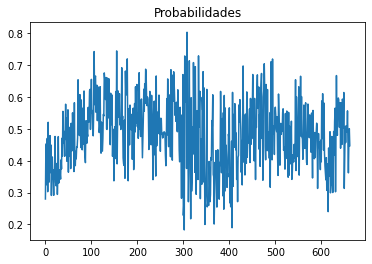

In [46]:
y_pred_train = melhor_modelo.predict(X_train)
y_pred_test = melhor_modelo.predict(X_test)

y_proba_train = melhor_modelo.predict_proba(X_train)[:,1]
y_proba_test = melhor_modelo.predict_proba(X_test)[:,1]
pd.Series(y_proba_test).plot(title = "Probabilidades")

#### Avaliação

In [47]:
# Treinamento
print(confusion_matrix(y_train, y_pred_train))
print()
print(accuracy_score(y_train, y_pred_train))
print()
print(classification_report(y_train, y_pred_train))

[[534 387]
 [613 505]]

0.5095635115252575

              precision    recall  f1-score   support

          -1       0.47      0.58      0.52       921
           1       0.57      0.45      0.50      1118

    accuracy                           0.51      2039
   macro avg       0.52      0.52      0.51      2039
weighted avg       0.52      0.51      0.51      2039



In [48]:
# Teste
print(confusion_matrix(y_test, y_pred_test))
print()
print(accuracy_score(y_test, y_pred_test))
print()
print(classification_report(y_test, y_pred_test))

[[170 136]
 [200 157]]

0.49321266968325794

              precision    recall  f1-score   support

          -1       0.46      0.56      0.50       306
           1       0.54      0.44      0.48       357

    accuracy                           0.49       663
   macro avg       0.50      0.50      0.49       663
weighted avg       0.50      0.49      0.49       663



AUC - Teste : 0.49603632302594236


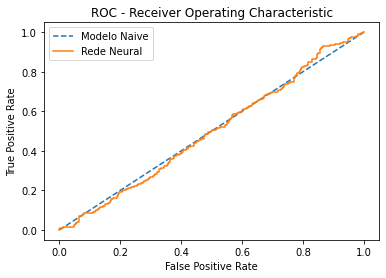

In [49]:
# Calculando a AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
print("AUC - Teste :", roc_auc)

# Criando Curva ROC
plt.plot([0,1], [0,1], linestyle = '--', label = 'Modelo Naive')
plt.plot(fpr, tpr, label = 'Rede Neural')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC - Receiver Operating Characteristic")
plt.legend()
plt.show()

#### Sinais

In [50]:
y_proba_train

array([0.40100134, 0.50809337, 0.59612652, ..., 0.32981622, 0.35081082,
       0.30296179])

In [51]:
n_q = 10

sinais = pd.DataFrame()
sinais["Observado"] = np.array(y_train)
sinais["Probabilidades"] = pd.Series(y_proba_train)
sinais["Quantil"] = pd.qcut(sinais["Probabilidades"], n_q, False)
sinais["Intervalo_Quantil"] = pd.qcut(sinais["Probabilidades"], n_q)

##### Automatização do Ponto de Corte 1:

In [52]:
# Automatização 1 (não funciona de maneira adequada pois os quantis são desordenados)

# quantis = pd.DataFrame()
# quantis["Compra"] = sinais[sinais["Observado"] == 0]["Quantil"].value_counts(sort = True)
# quantis["Venda"] = sinais[sinais["Observado"] == 1]["Quantil"].value_counts(sort = True)
# quantis = quantis.reset_index().rename(columns = {"index" : "Quantil"})

#quantis["Indecisão Compra"] = np.where(quantis["Compra"] < quantis["Venda"], 1, 0)
#quantis["Indecisão Venda"] = np.where(quantis["Compra"] > quantis["Venda"], 1, 0)

#lim_venda = quantis[quantis["Indecisão Venda"] == 1]["Quantil"].max()
#lim_compra = quantis[quantis["Indecisão Compra"] == 1]["Quantil"].min()

# lim_venda = 6 # limite superior
# lim_compra = 11 # limite inferior

# corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
# corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right

# print("Probabilidades de corte:", corte_venda, corte_compra)
# print("Quantis:", lim_venda, lim_compra)

# sinais.head()

##### Automatização do Ponto de Corte 2:

In [53]:
# Automatização 2:
pares = []
for i in range(n_q):
    for j in range(n_q):
        if i < j:
            pares.append((i,j))
            
def backtest(par):

    lim_venda = par[0]
    lim_compra = par[1]
    
    corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
    corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right
    
    resultado = pd.DataFrame()
    resultado["Observado"] = np.array(y_train)
    resultado["Probabilidades"] = pd.Series(y_proba_train)
    resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))

    bt = pd.DataFrame()
    bt["Alvo"] = df["Alvo_Contínuo"][ini_treino:fim_treino].reset_index(drop = True)
    bt["Sinal"] = resultado["Operação"]
    bt.index = df["Alvo_Contínuo"][ini_treino:fim_treino].index
    bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, bt["Alvo"], 0))
    bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()

    return bt.tail(1)["Retorno Acumulado"].values

retornos = []
for i in pares:
    retornos.append(backtest(i))
    
print("Maior retorno no treinamento:", max(retornos))
print("Quantis de Corte", pares[retornos.index(max(retornos))])

lim_compra = pares[retornos.index(max(retornos))][1]
lim_venda = pares[retornos.index(max(retornos))][0]

corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right

Maior retorno no treinamento: [853.40860862]
Quantis de Corte (5, 7)


#### Backtest

Retorno BH: [368.67672704] %
Retorno do Modelo: [299.84834914] %


<AxesSubplot:xlabel='Data'>

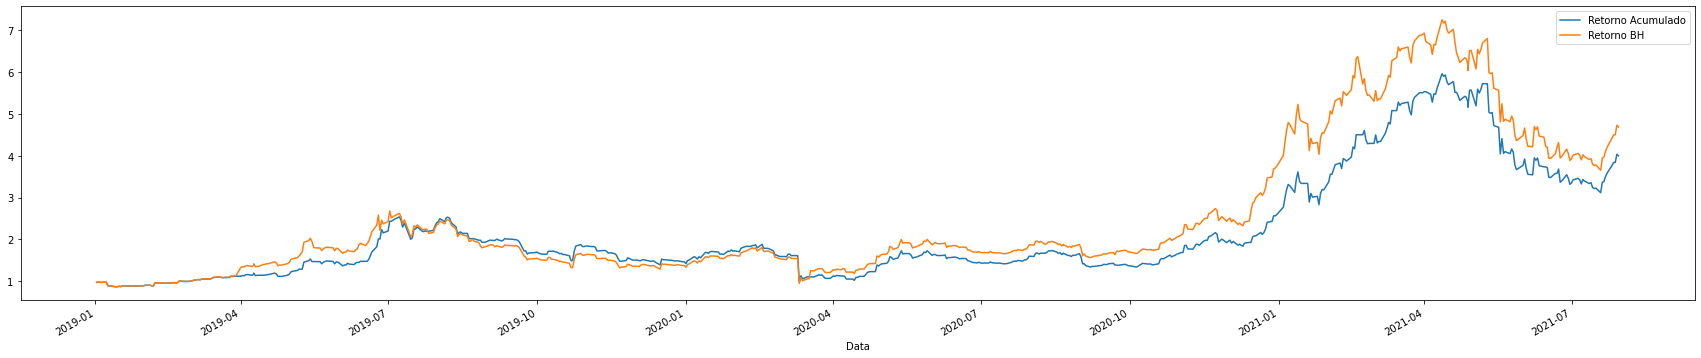

In [54]:
resultado = pd.DataFrame()
resultado["Observado"] = np.array(y_test)
resultado["Probabilidades"] = pd.Series(y_proba_test)
resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))
resultado["Operação"].value_counts()

bt = pd.DataFrame()
bt["Alvo"] = df["Alvo_Contínuo"][ini_teste:fim_teste].reset_index(drop = True)
bt["Sinal"] = resultado["Operação"]
bt.index = df["Alvo_Contínuo"][ini_teste:fim_teste].index

bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, bt["Alvo"], 0))

bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()
bt["Retorno BH"] = (bt["Alvo"] + 1).cumprod()

print("Retorno BH:", (bt.tail(1)["Retorno BH"].values-1)*100, "%")
print("Retorno do Modelo:", (bt.tail(1)["Retorno Acumulado"].values-1)*100, "%")

bt[["Retorno Acumulado", "Retorno BH"]].plot(figsize=(30,6))

In [55]:
# Acrescentando Stop
# stop = 0.3
# bt = bt.join(df[["Stop_Long", "Stop_Short"]])
# bt["Retorno Long"] = np.where(bt["Sinal"] == 1, bt["Alvo"], 0)
# bt["Retorno Short"] = np.where(bt["Sinal"] == -1, -bt["Alvo"], 0)
# # bt["Retorno Long"] = np.where(bt["Stop_Long"] == 1, -stop, bt["Retorno Long"])
# # bt["Retorno Short"] = np.where(bt["Stop_Short"] == 1, -stop, bt["Retorno Short"])
# bt["Retorno Diário"] = bt["Retorno Long"] + bt["Retorno Short"]